In [ ]:
# https://keras.io/examples/vision/segformer/

# 🏿 GPU and CUDA

In [1]:
from psutil import virtual_memory       
gpu = !nvidia-smi --query-gpu=gpu_name --format=csv,noheader
ram_gb = virtual_memory().total / 1e9
print(f'{gpu.s} with {round(ram_gb,1)} GB of available RAM.\n')
!nvcc --version

NVIDIA GeForce RTX 3090 with 34.2 GB of available RAM.

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2021 NVIDIA Corporation
Built on Sun_Feb_14_22:08:44_Pacific_Standard_Time_2021
Cuda compilation tools, release 11.2, V11.2.152
Build cuda_11.2.r11.2/compiler.29618528_0


# ⚙ Configurations

In [2]:
import os
DIR = os.getcwd()
ANN_FILE = os.path.join(DIR, 'data\\result.json')
MSKS_DIR = os.path.join(DIR, 'data\\masks')
IMGS_DIR = os.path.join(DIR, 'data\\images')
NO_LABEL_DIR = os.path.join(DIR, 'output_MSRCR_total\\1')
CHCKPNT_MODELS = os.path.join(DIR, 'checkpoints\\deeplabv3')
BATCH_SIZE = 4
# IMG_SIZE = (256,256)
IMG_SIZE = (512,512)
SEED = 42

In [3]:
# force a channel ordering
from keras import backend
# force channels-first ordering
#backend.set_image_data_format('channels_first')
print(backend.image_data_format())

channels_first


# COCO format dataset 

In [3]:
# for Windows, install pycocotools with conda
import pycocotools
from pycocotools.coco import COCO
dset = COCO(ANN_FILE)

loading annotations into memory...
Done (t=0.01s)
creating index...
index created!


In [4]:
catIDs = dset.getCatIds()
cats = dset.loadCats(catIDs)
print(f"Categories: {cats}")

Categories: [{'id': 0, 'name': 'background'}, {'id': 1, 'name': 'reef'}]


# Data Preparation

In [155]:
import tensorflow as tf

train_imgs, val_imgs = tf.keras.utils.image_dataset_from_directory(
  IMGS_DIR,
  validation_split=0.15,
  subset="both",
  seed=SEED,
  image_size=IMG_SIZE,
  batch_size=BATCH_SIZE)

train_msks, val_msks = tf.keras.utils.image_dataset_from_directory(
  MSKS_DIR,
  validation_split=0.15,
  subset="both",
  color_mode='grayscale',
  seed=SEED,
  image_size=IMG_SIZE,
  batch_size=BATCH_SIZE)

Found 36 files belonging to 1 classes.
Using 31 files for training.
Using 5 files for validation.
Found 36 files belonging to 1 classes.
Using 31 files for training.
Using 5 files for validation.


In [43]:
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec    # configurar grelha de graficos
import cv2                                # visão artificial, manipulacão de imagens
import numpy as np

def analisa_img(img_caminho, val_unic = False):
    """
    Analisa propriedades duma imagem.

    Parâmetros:
      img_caminho{str}: caminho do ficheiro da imagem
      val_unic{bool}: True: imprime valores de pixel unicos; False: nao imprime 

    """
    fig = plt.figure(figsize=(20,15), constrained_layout=False)
    gs = gridspec.GridSpec(nrows = 2, ncols= 3, )
    gs.update(hspace=0.05, wspace=0.15)

    img = cv2.imread(img_caminho)
    img=  cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
    print(f'Imagem com {os.path.getsize(img_caminho)} bytes')
    print(f'Tipo de imagem: {type(img)}') 
    print(f'Dimensoes da imagem (Altura, Largura, Canais): {img.shape}')
    print(f'Valor pixel maximo [{img.max()}] e minimo [{img.min()}]')
    if val_unic == True:
        print(f'Valores unicos {np.unique(img)}')

    ax1 = fig.add_subplot(gs[0, 0])
    ax1.set_title(f'Ficheiro: "{os.path.basename(img_caminho)} "')
    ax1.set_ylabel('Largura {}'.format(img.shape[1])) 
    ax1.set_xlabel('Altura {}'.format(img.shape[0])) 
    ax1.imshow(img)

    ax2 = fig.add_subplot(gs[0, 1:])
    color = ('b','g','r')
    for channel,col in enumerate(color):
        histr = cv2.calcHist([img],[channel],None,[256],[0,256])
        ax2.plot(histr,color = col)
        ax2.set_xlim([0,256])
        ax2.legend(['Canal AZUL', 'Canal VERDE', 'Canal VERMELHO'])
    ax2.set_title('Histograma para imagens RGB')

    ax3 = fig.add_subplot(gs[1, 0])
    ax3.set_title('Canal VERMELHO') 
    ax3.set_ylabel('Largura {}'.format(img.shape[1])) 
    ax3.set_xlabel('Altura {}'.format(img.shape[0])) 
    ax3.imshow(img[ : , : , 0], cmap = 'gray')

    ax4 = fig.add_subplot(gs[1, 1])
    ax4.set_title('Canal VERDE') 
    ax4.set_ylabel('Largura {}'.format(img.shape[1])) 
    ax4.set_xlabel('Altura {}'.format(img.shape[0])) 
    ax4.imshow(img[ : , : , 1], cmap = 'gray')

    ax5 = fig.add_subplot(gs[1, 2])
    ax5.set_title('Canal AZUL') 
    ax5.set_ylabel('Largura {}'.format(img.shape[1])) 
    ax5.set_xlabel('Altura {}'.format(img.shape[0])) 
    ax5.imshow(img[ : , : , 2], cmap = 'gray')


Imagem com 637 bytes
Tipo de imagem: <class 'numpy.ndarray'>
Dimensoes da imagem (Altura, Largura, Canais): (600, 800, 3)
Valor pixel maximo [255] e minimo [0]
Valores unicos [  0   5   8  16  17  77 183 255]


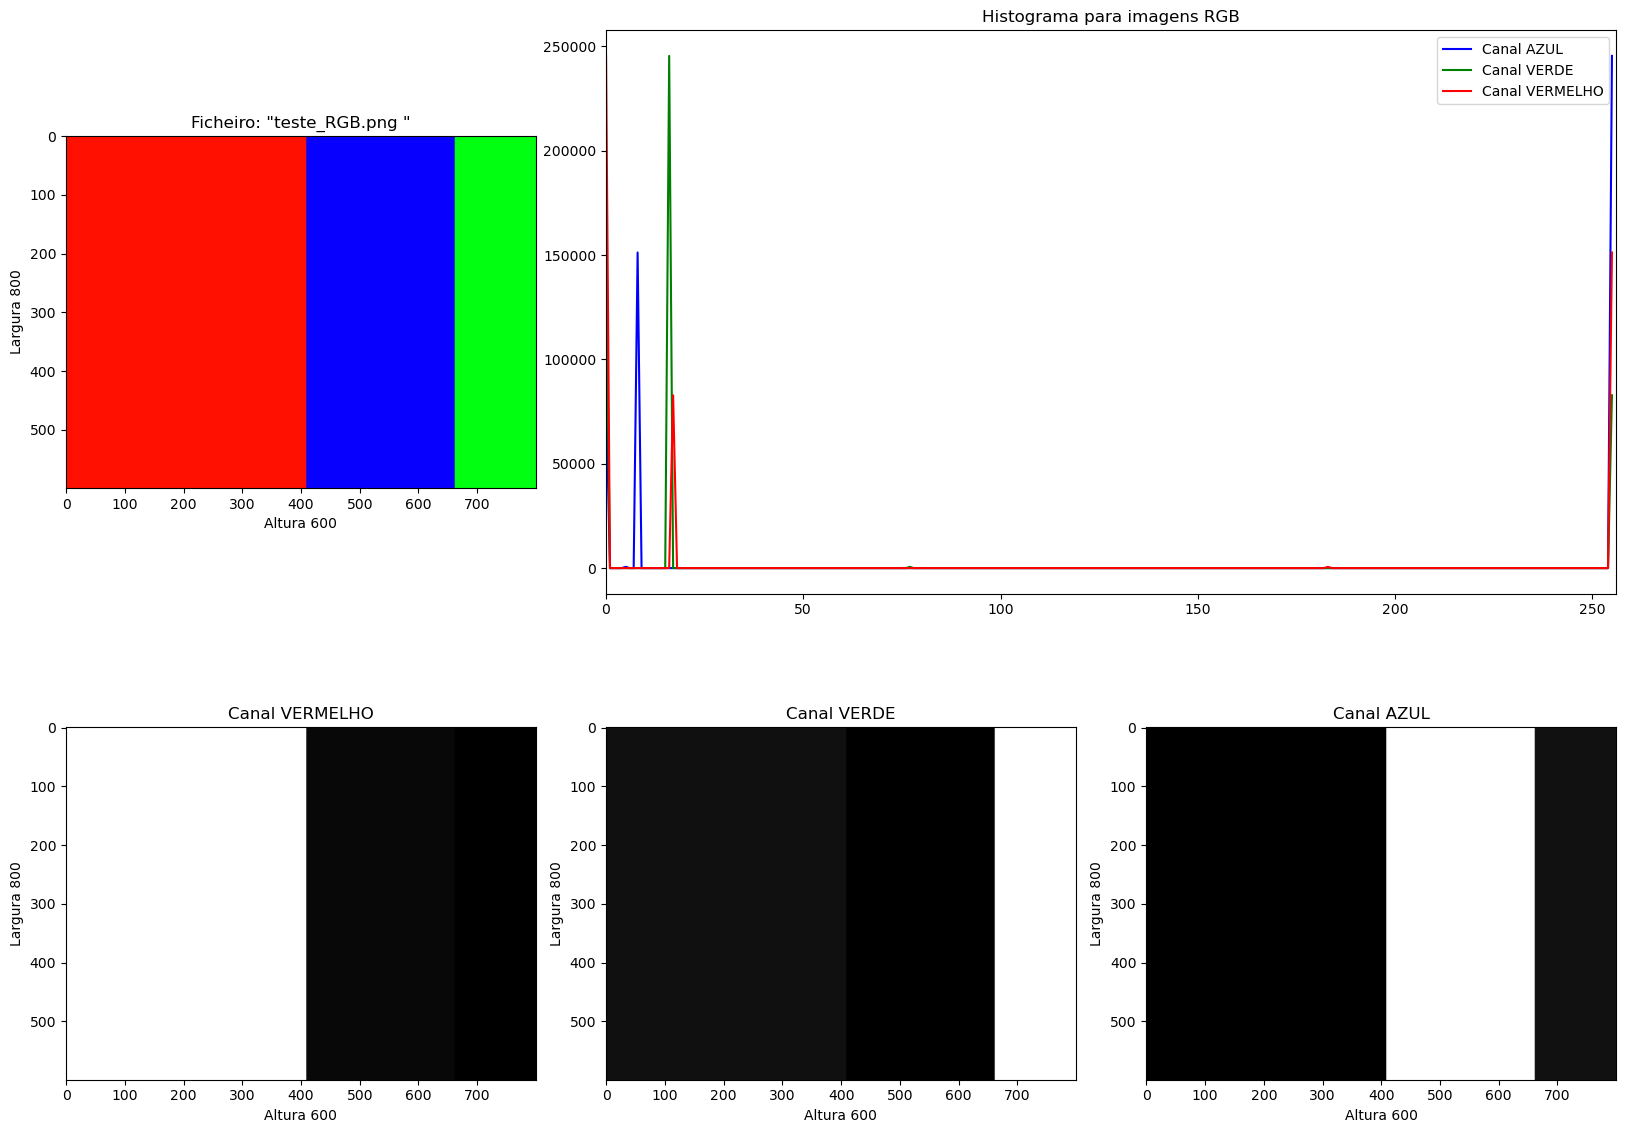

In [44]:
analisa_img('teste_RGB.png', val_unic = True)

## Training Subset Mean and Standard Deviation Calculation

In [138]:
mean_list, std_list = list(), list()
for msk_path in train_msks.file_paths:
    msk_img = tf.keras.utils.load_img(msk_path, color_mode = "grayscale")
    mean= np.mean(msk_img, axis=(0,1))
    std = np.std(msk_img, axis=(0,1))
    mean_list.append(mean)
    std_list.append(std)
mean_msks = np.mean(mean_list)
std_msks = np.std(std_list)

In [139]:
mean_list, std_list = list(), list()
for img_path in train_imgs.file_paths:
    img = tf.keras.utils.load_img(img_path, color_mode = "rgb")
    mean = np.mean(img, axis=(0,1))
    std = np.std(img, axis=(0,1))
    std_list.append(std)
    mean_list.append(mean)
mean_imgs = np.mean(mean_list, axis = 0)
std_imgs = np.std(std_list, axis = 0)

# CONTINUAR: já se tem a média e desvio padrão agora é normalizar
# https://keras.io/examples/vision/segformer/

In [53]:
import numpy as np
np.shape(msk_img)

(600, 800, 3)

# SegFormer Model

 ![](segformer.PNG "SegFormer Diagram")

In [ ]:
# Calculate mean value for each channel (test set only)

In [13]:
import tensorflow as tf
from tensorflow.keras import backend

In [ ]:
import tensorflow as tf
from tensorflow.keras import backend

image_size = 512
mean = tf.constant(mean_imgs)
std = tf.constant(std_imgs)

def normalize(input_image, input_mask):
    input_image = tf.image.convert_image_dtype(input_image, tf.float32)
    input_image = (input_image - mean) / tf.maximum(std, backend.epsilon())
    input_mask = input_mask/255.0
    input_mask -= 1
    return input_image, input_mask


def load_image(datapoint):
    input_image = tf.image.resize(datapoint["image"], (IMG_SIZE[0], IMG_SIZE[1]))
    input_mask = tf.image.resize(
        datapoint["segmentation_mask"],
        (image_size, image_size),
        method="bilinear",
    )

    input_image, input_mask = normalize(input_image, input_mask)
    input_image = tf.transpose(input_image, (2, 0, 1))
    return {"pixel_values": input_image, "labels": tf.squeeze(input_mask)}

In [145]:
IMG_SIZE[1]

512

In [13]:
from transformers import TFSegformerForSemanticSegmentation

model_checkpoint = "nvidia/mit-b0"

id2label = {0: "background", 1: "reef"}
label2id = {label: id for id, label in id2label.items()}
num_labels = len(id2label)
model = TFSegformerForSemanticSegmentation.from_pretrained(
    model_checkpoint,
    num_labels=num_labels,
    id2label=id2label,
    label2id=label2id,
    ignore_mismatched_sizes=True,
)

ValueError: Exception encountered when calling layer "dwconv" "                 f"(type TFSegformerDWConv).

The number of input channels must be evenly divisible by the number of groups. Received groups=128, but the input has 32 channels (full input shape is (3, 32, 128, 128)).

Call arguments received by layer "dwconv" "                 f"(type TFSegformerDWConv):
  • hidden_states=tf.Tensor(shape=(3, 4096, 128), dtype=float32)
  • height=32
  • width=128

In [ ]:
from tensorflow.keras.optimizers import Adam
from segmentation_models.metrics import iou_score        # test different iou score calculation
# from tensorflow.keras.metrics import MeanIoU           # or Jaccard Index
from tensorflow.keras.metrics import Precision         
from tensorflow.keras.metrics import Recall         
model.compile(optimizer = Adam(learning_rate=0.001), 
              loss = 'binary_crossentropy',
              metrics= ['accuracy', Precision(thresholds=0.5), Recall(thresholds=0.5)]
             )

In [12]:
def string_run(model_name = 'NET', fold = [], val_cruz = False):
    """
    Creates a string for the run.
    """
    from datetime import datetime
    now = datetime.now()
    dt_string = now.strftime("%d_%b_%Hh%Mmin")
    str_run = f"{model_name}_DT_{dt_string}"
    if val_cruz == True:
        str_run = str_run + "_fold_" + str(fold)
    print(f'run designation: \033[1m{str_run}\033[0m')
    return str_run

# Data Augmentation

## Images Data Augmentation

In [9]:
# https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/image/ImageDataGenerator
# https://stackoverflow.com/questions/56517963/keras-imagedatagenerator-for-segmentation-with-images-and-masks-in-separate-dire
from keras.preprocessing.image import ImageDataGenerator

img_gen = ImageDataGenerator(samplewise_center=True,
                             samplewise_std_normalization=True,
                             rotation_range = 30,
                             shear_range = 0.3,
                             fill_mode='reflect',        # "constant", "nearest", "reflect" or "wrap"
                             horizontal_flip=True, 
                             zoom_range = [0.4, 1],
                             brightness_range=[0.5,1.2],
                             data_format="channels_first",
                             validation_split = 0.15,
                             rescale=1./255)

img_gen_valid = ImageDataGenerator(samplewise_center=True,
                                   samplewise_std_normalization=True,
                                   data_format="channels_first",
                                   validation_split = 0.15,
                                   rescale=1./255)

img_trn_dset = img_gen.flow_from_directory(directory = IMGS_DIR,
                                           batch_size = BATCH_SIZE,
                                           target_size = IMG_SIZE,
                                           color_mode="rgb",
                                           class_mode=None,
                                           subset="training",
                                           seed = SEED)

img_vld_dset = img_gen_valid.flow_from_directory(directory = IMGS_DIR,
                                                 batch_size = BATCH_SIZE,
                                                 target_size = IMG_SIZE,
                                                 color_mode="rgb",
                                                 class_mode=None,
                                                 subset="validation",
                                                 seed = SEED)

Found 31 images belonging to 1 classes.
Found 5 images belonging to 1 classes.


## Masks Data Augmentation

In [10]:
msk_gen = ImageDataGenerator(samplewise_center=True,
                             samplewise_std_normalization=True,
                             rotation_range = 30,
                             shear_range = 0.3,
                             fill_mode='reflect',        # "constant", "nearest", "reflect" or "wrap"
                             horizontal_flip=True, 
                             zoom_range = [0.5, 1],
                             data_format="channels_first",
                             validation_split = 0.15,
                             rescale=1./255
                            )

# msk_gen.fit()

# print('Data Generator mean=%.3f, std=%.3f' % (msk_gen.mean, msk_gen.std))

msk_gen_valid = ImageDataGenerator(samplewise_center=True,
                                   samplewise_std_normalization=True,
                                   data_format="channels_first",
                                   validation_split = 0.15,
                                   rescale=1./255)

msk_trn_dset = msk_gen.flow_from_directory(directory = MSKS_DIR,
                                           batch_size = BATCH_SIZE,
                                           target_size = IMG_SIZE,
                                           color_mode="grayscale",
                                           class_mode=None,
                                           subset="training",
                                           seed = SEED)

msk_vld_dset = msk_gen_valid.flow_from_directory(directory = MSKS_DIR,
                                                 batch_size = BATCH_SIZE,
                                                 target_size = IMG_SIZE,
                                                 color_mode="grayscale",
                                                 class_mode=None,
                                                 subset="validation",
                                                 seed = SEED)

Found 31 images belonging to 1 classes.
Found 5 images belonging to 1 classes.


In [11]:
str_run = string_run(model_name = 'SegFormer')
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor = 'loss',
                                              factor = 0.5,    # fator de reducao tx. aprendizagem
                                              mode = 'min',    # tx. apr. diminui se IoU nao aumentar
                                              patience = 20,   # epocas ate reducao tx. aprendizagem
                                              verbose = 1,     # verbosidade
                                              min_lr = 1e-6)   # tx.aprendizagem inicial = 0.1

chckpnt_cb = tf.keras.callbacks.ModelCheckpoint(filepath = os.path.join(CHCKPNT_MODELS, str_run + '.h5'),
                                             save_best_only = True,
                                             mode = 'max',
                                             verbose = 1, 
                                             monitor = "val_accuracy")

NameError: name 'string_run' is not defined

In [150]:
train_generator = zip(img_trn_dset, msk_trn_dset)
valid_generator = zip(img_vld_dset, msk_vld_dset)

In [151]:
%%time
# 🏋🏽 trains the model
history = model.fit(train_generator,
                    validation_data = valid_generator,
                    epochs = 1000,
                    batch_size = BATCH_SIZE,
                    verbose = 1,
                    steps_per_epoch = (img_trn_dset.n // BATCH_SIZE)*5,
                    validation_steps = img_vld_dset.n // BATCH_SIZE,
                    validation_batch_size = BATCH_SIZE,
                    callbacks = [reduce_lr, chckpnt_cb])

Epoch 1/1000


InvalidArgumentError: Graph execution error:

Detected at node 'tf_segformer_for_semantic_segmentation/segformer/encoder/patch_embeddings.0/proj/Conv2D' defined at (most recent call last):
    File "C:\Users\tiago\miniconda3\envs\tf2_10\lib\runpy.py", line 196, in _run_module_as_main
      return _run_code(code, main_globals, None,
    File "C:\Users\tiago\miniconda3\envs\tf2_10\lib\runpy.py", line 86, in _run_code
      exec(code, run_globals)
    File "C:\Users\tiago\miniconda3\envs\tf2_10\lib\site-packages\ipykernel_launcher.py", line 17, in <module>
      app.launch_new_instance()
    File "C:\Users\tiago\miniconda3\envs\tf2_10\lib\site-packages\traitlets\config\application.py", line 846, in launch_instance
      app.start()
    File "C:\Users\tiago\miniconda3\envs\tf2_10\lib\site-packages\ipykernel\kernelapp.py", line 712, in start
      self.io_loop.start()
    File "C:\Users\tiago\miniconda3\envs\tf2_10\lib\site-packages\tornado\platform\asyncio.py", line 215, in start
      self.asyncio_loop.run_forever()
    File "C:\Users\tiago\miniconda3\envs\tf2_10\lib\asyncio\base_events.py", line 595, in run_forever
      self._run_once()
    File "C:\Users\tiago\miniconda3\envs\tf2_10\lib\asyncio\base_events.py", line 1881, in _run_once
      handle._run()
    File "C:\Users\tiago\miniconda3\envs\tf2_10\lib\asyncio\events.py", line 80, in _run
      self._context.run(self._callback, *self._args)
    File "C:\Users\tiago\miniconda3\envs\tf2_10\lib\site-packages\ipykernel\kernelbase.py", line 510, in dispatch_queue
      await self.process_one()
    File "C:\Users\tiago\miniconda3\envs\tf2_10\lib\site-packages\ipykernel\kernelbase.py", line 499, in process_one
      await dispatch(*args)
    File "C:\Users\tiago\miniconda3\envs\tf2_10\lib\site-packages\ipykernel\kernelbase.py", line 406, in dispatch_shell
      await result
    File "C:\Users\tiago\miniconda3\envs\tf2_10\lib\site-packages\ipykernel\kernelbase.py", line 730, in execute_request
      reply_content = await reply_content
    File "C:\Users\tiago\miniconda3\envs\tf2_10\lib\site-packages\ipykernel\ipkernel.py", line 383, in do_execute
      res = shell.run_cell(
    File "C:\Users\tiago\miniconda3\envs\tf2_10\lib\site-packages\ipykernel\zmqshell.py", line 528, in run_cell
      return super().run_cell(*args, **kwargs)
    File "C:\Users\tiago\miniconda3\envs\tf2_10\lib\site-packages\IPython\core\interactiveshell.py", line 2940, in run_cell
      result = self._run_cell(
    File "C:\Users\tiago\miniconda3\envs\tf2_10\lib\site-packages\IPython\core\interactiveshell.py", line 2995, in _run_cell
      return runner(coro)
    File "C:\Users\tiago\miniconda3\envs\tf2_10\lib\site-packages\IPython\core\async_helpers.py", line 129, in _pseudo_sync_runner
      coro.send(None)
    File "C:\Users\tiago\miniconda3\envs\tf2_10\lib\site-packages\IPython\core\interactiveshell.py", line 3194, in run_cell_async
      has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
    File "C:\Users\tiago\miniconda3\envs\tf2_10\lib\site-packages\IPython\core\interactiveshell.py", line 3373, in run_ast_nodes
      if await self.run_code(code, result, async_=asy):
    File "C:\Users\tiago\miniconda3\envs\tf2_10\lib\site-packages\IPython\core\interactiveshell.py", line 3433, in run_code
      exec(code_obj, self.user_global_ns, self.user_ns)
    File "C:\Users\tiago\AppData\Local\Temp\ipykernel_12228\715056932.py", line 1, in <module>
      get_ipython().run_cell_magic('time', '', '# 🏋🏽 trains the model\nhistory = model.fit(train_generator,\n                    validation_data = valid_generator,\n                    epochs = 1000,\n                    batch_size = BATCH_SIZE,\n                    verbose = 1,\n                    steps_per_epoch = (img_trn_dset.n // BATCH_SIZE)*5,\n                    validation_steps = img_vld_dset.n // BATCH_SIZE,\n                    validation_batch_size = BATCH_SIZE,\n                    callbacks = [reduce_lr, chckpnt_cb])\n')
    File "C:\Users\tiago\miniconda3\envs\tf2_10\lib\site-packages\IPython\core\interactiveshell.py", line 2417, in run_cell_magic
      result = fn(*args, **kwargs)
    File "C:\Users\tiago\miniconda3\envs\tf2_10\lib\site-packages\IPython\core\magics\execution.py", line 1316, in time
      exec(code, glob, local_ns)
    File "<timed exec>", line 2, in <module>
    File "C:\Users\tiago\miniconda3\envs\tf2_10\lib\site-packages\keras\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "C:\Users\tiago\miniconda3\envs\tf2_10\lib\site-packages\keras\engine\training.py", line 1564, in fit
      tmp_logs = self.train_function(iterator)
    File "C:\Users\tiago\miniconda3\envs\tf2_10\lib\site-packages\keras\engine\training.py", line 1160, in train_function
      return step_function(self, iterator)
    File "C:\Users\tiago\miniconda3\envs\tf2_10\lib\site-packages\keras\engine\training.py", line 1146, in step_function
      outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "C:\Users\tiago\miniconda3\envs\tf2_10\lib\site-packages\keras\engine\training.py", line 1135, in run_step
      outputs = model.train_step(data)
    File "C:\Users\tiago\miniconda3\envs\tf2_10\lib\site-packages\transformers\modeling_tf_utils.py", line 1535, in train_step
      y_pred = self(x, training=True)
    File "C:\Users\tiago\miniconda3\envs\tf2_10\lib\site-packages\keras\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "C:\Users\tiago\miniconda3\envs\tf2_10\lib\site-packages\keras\engine\training.py", line 557, in __call__
      return super().__call__(*args, **kwargs)
    File "C:\Users\tiago\miniconda3\envs\tf2_10\lib\site-packages\keras\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "C:\Users\tiago\miniconda3\envs\tf2_10\lib\site-packages\keras\engine\base_layer.py", line 1097, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "C:\Users\tiago\miniconda3\envs\tf2_10\lib\site-packages\keras\utils\traceback_utils.py", line 96, in error_handler
      return fn(*args, **kwargs)
    File "C:\Users\tiago\miniconda3\envs\tf2_10\lib\site-packages\transformers\modeling_tf_utils.py", line 830, in run_call_with_unpacked_inputs
      raise e
    File "C:\Users\tiago\miniconda3\envs\tf2_10\lib\site-packages\transformers\models\segformer\modeling_tf_segformer.py", line 857, in call
      outputs = self.segformer(
    File "C:\Users\tiago\miniconda3\envs\tf2_10\lib\site-packages\keras\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "C:\Users\tiago\miniconda3\envs\tf2_10\lib\site-packages\keras\engine\base_layer.py", line 1097, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "C:\Users\tiago\miniconda3\envs\tf2_10\lib\site-packages\keras\utils\traceback_utils.py", line 96, in error_handler
      return fn(*args, **kwargs)
    File "C:\Users\tiago\miniconda3\envs\tf2_10\lib\site-packages\transformers\modeling_tf_utils.py", line 830, in run_call_with_unpacked_inputs
      raise e
    File "C:\Users\tiago\miniconda3\envs\tf2_10\lib\site-packages\transformers\models\segformer\modeling_tf_segformer.py", line 481, in call
      encoder_outputs = self.encoder(
    File "C:\Users\tiago\miniconda3\envs\tf2_10\lib\site-packages\keras\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "C:\Users\tiago\miniconda3\envs\tf2_10\lib\site-packages\keras\engine\base_layer.py", line 1097, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "C:\Users\tiago\miniconda3\envs\tf2_10\lib\site-packages\keras\utils\traceback_utils.py", line 96, in error_handler
      return fn(*args, **kwargs)
    File "C:\Users\tiago\miniconda3\envs\tf2_10\lib\site-packages\transformers\models\segformer\modeling_tf_segformer.py", line 413, in call
      for idx, x in enumerate(zip(self.embeddings, self.block, self.layer_norms)):
    File "C:\Users\tiago\miniconda3\envs\tf2_10\lib\site-packages\transformers\models\segformer\modeling_tf_segformer.py", line 416, in call
      hidden_states, height, width = embedding_layer(hidden_states)
    File "C:\Users\tiago\miniconda3\envs\tf2_10\lib\site-packages\keras\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "C:\Users\tiago\miniconda3\envs\tf2_10\lib\site-packages\keras\engine\base_layer.py", line 1097, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "C:\Users\tiago\miniconda3\envs\tf2_10\lib\site-packages\keras\utils\traceback_utils.py", line 96, in error_handler
      return fn(*args, **kwargs)
    File "C:\Users\tiago\miniconda3\envs\tf2_10\lib\site-packages\transformers\models\segformer\modeling_tf_segformer.py", line 89, in call
      embeddings = self.proj(self.padding(pixel_values))
    File "C:\Users\tiago\miniconda3\envs\tf2_10\lib\site-packages\keras\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "C:\Users\tiago\miniconda3\envs\tf2_10\lib\site-packages\keras\engine\base_layer.py", line 1097, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "C:\Users\tiago\miniconda3\envs\tf2_10\lib\site-packages\keras\utils\traceback_utils.py", line 96, in error_handler
      return fn(*args, **kwargs)
    File "C:\Users\tiago\miniconda3\envs\tf2_10\lib\site-packages\keras\layers\convolutional\base_conv.py", line 283, in call
      outputs = self.convolution_op(inputs, self.kernel)
    File "C:\Users\tiago\miniconda3\envs\tf2_10\lib\site-packages\keras\layers\convolutional\base_conv.py", line 255, in convolution_op
      return tf.nn.convolution(
Node: 'tf_segformer_for_semantic_segmentation/segformer/encoder/patch_embeddings.0/proj/Conv2D'
input depth must be evenly divisible by filter depth: 512 vs 3
	 [[{{node tf_segformer_for_semantic_segmentation/segformer/encoder/patch_embeddings.0/proj/Conv2D}}]] [Op:__inference_train_function_28071]